In [1]:
import numpy as np 
import struct
from array import array
from os.path  import join
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time

In [2]:
#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)     

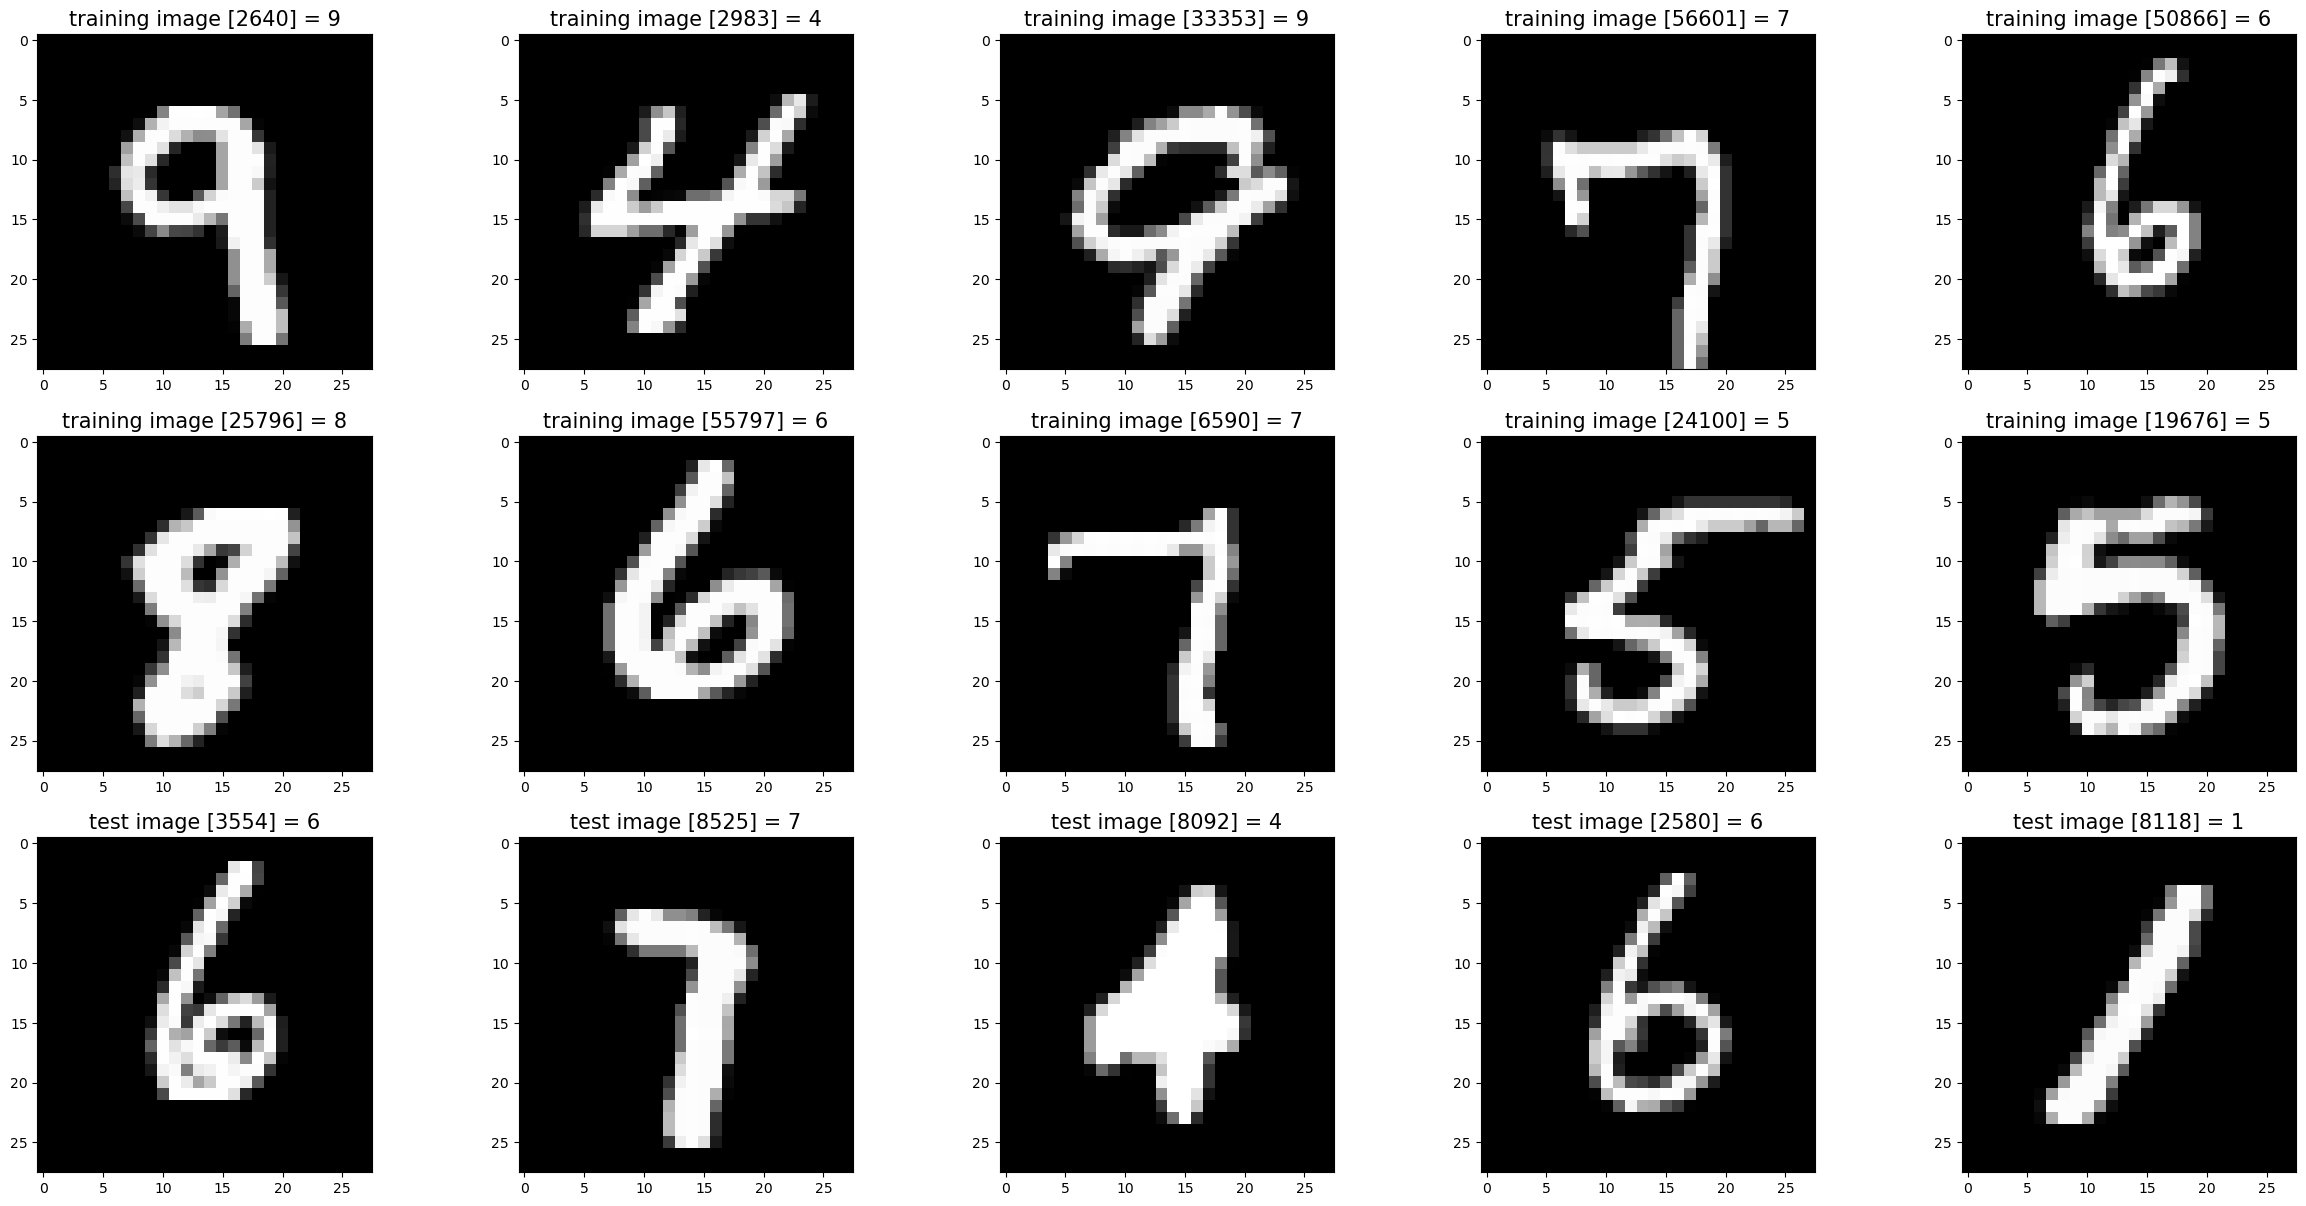

In [3]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#


training_images_filepath = 'train-images-idx3-ubyte/train-images-idx3-ubyte'
training_labels_filepath = 'train-labels-idx1-ubyte/train-labels-idx1-ubyte'
test_images_filepath =  't10k-images-idx3-ubyte/t10k-images-idx3-ubyte'
test_labels_filepath = 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte'

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

reference:https://www.kaggle.com/code/hojjatk/read-mnist-dataset/notebook

In [4]:
# Flatten the images for KNN
x_train = np.array(x_train)
x_test = np.array(x_test)

x_train_flattened = x_train.reshape(x_train.shape[0], -1)
x_test_flattened = x_test.reshape(x_test.shape[0], -1)

y_test = np.array(y_test)
y_train = np.array(y_train)

In [5]:
#baseline selection method, randomly select
def baseline_select_prototype(x_train_input, y_train_input, M):
    x_train_input = np.array(x_train_input)
    y_train_input = np.array(y_train_input)
    
    indices = np.arange(len(x_train_input))
    np.random.shuffle(indices)
    
    selected_indices = indices[:M]
    
    x_train_prototypes = x_train_input[selected_indices]
    y_train_prototypes = y_train_input[selected_indices]
    
    return x_train_prototypes, y_train_prototypes

In [6]:
def equal_num_label_select_prototype(x_train_input, y_train_input, M):
    # Ensure the inputs are numpy arrays
    x_train_input = np.array(x_train_input)
    y_train_input = np.array(y_train_input)
    
    # Initialize lists to hold the selected prototypes and their labels
    x_train_prototypes = []
    y_train_prototypes = []
    
    # Calculate the number of samples per class
    samples_per_class = M // 10
    
    for digit in range(10):
        # Find the indices of all samples with the current digit
        indices = np.where(y_train_input == digit)[0]
        
        # Shuffle the indices
        np.random.shuffle(indices)
        
        # Select the first samples_per_class indices
        selected_indices = indices[:samples_per_class]
        
        # Add the selected samples and their labels to the lists
        x_train_prototypes.extend(x_train_input[selected_indices])
        y_train_prototypes.extend(y_train_input[selected_indices])
    
    # Convert the lists to numpy arrays
    x_train_prototypes = np.array(x_train_prototypes)
    y_train_prototypes = np.array(y_train_prototypes)
    
    return x_train_prototypes, y_train_prototypes

In [28]:
def KNN(x_input, y_input):
    knn = KNeighborsClassifier(n_neighbors=1)
    start_time = time.time()
    knn.fit(x_input, y_input)
    predictions = knn.predict(x_test_flattened)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"The execution time is {execution_time} seconds")
    return predictions
    

In [29]:
def get_accuracy(prediction):
    start_time = time.time()
    accuracy = accuracy_score(y_test, prediction)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f'Accuracy: {accuracy}')
    return accuracy

For M equals 10000: 
The execution time is 2.1760900020599365 seconds
Accuracy: 0.9501
For M equals 9000: 
The execution time is 1.9487690925598145 seconds
Accuracy: 0.9462
For M equals 8000: 
The execution time is 1.7635769844055176 seconds
Accuracy: 0.946
For M equals 7000: 
The execution time is 1.6202061176300049 seconds
Accuracy: 0.9435
For M equals 6000: 
The execution time is 1.4077789783477783 seconds
Accuracy: 0.9389
For M equals 5000: 
The execution time is 1.168820858001709 seconds
Accuracy: 0.9369
For M equals 4000: 
The execution time is 1.0053231716156006 seconds
Accuracy: 0.9361
For M equals 3000: 
The execution time is 0.7859640121459961 seconds
Accuracy: 0.9297
For M equals 2000: 
The execution time is 0.5576910972595215 seconds
Accuracy: 0.9083
For M equals 1000: 
The execution time is 0.3012351989746094 seconds
Accuracy: 0.8863


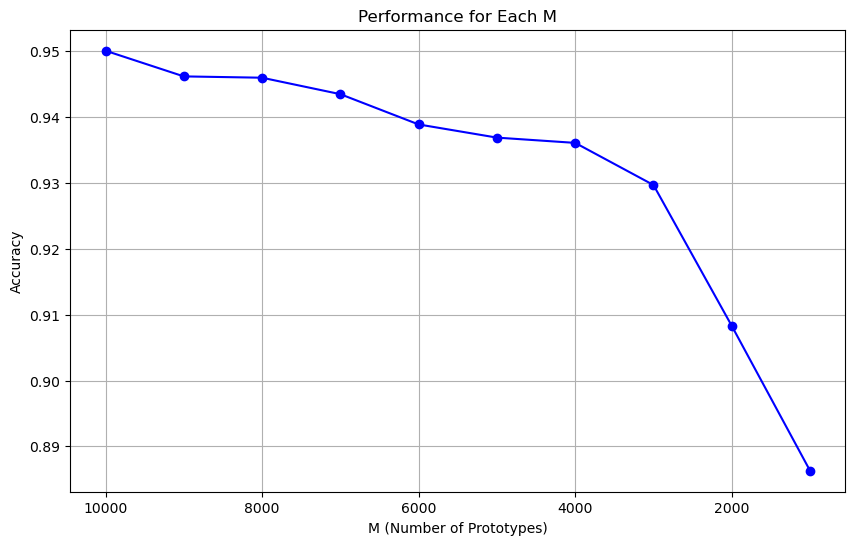

In [32]:
Ms = [10000, 9000, 8000, 7000, 6000, 5000, 4000, 3000, 2000, 1000]
accuracies = []
for M in Ms:
    print(f"For M equals {M}: ")
    x_select_train, y_select_train = baseline_select_prototype(x_train_flattened, y_train, M)
    p = KNN(x_select_train, y_select_train)
    accuracy = get_accuracy(p)
    accuracies.append(accuracy)
plt.figure(figsize=(10, 6))
plt.plot(Ms, accuracies, marker='o', linestyle='-', color='b')
plt.title('Performance for Each M')
plt.xlabel('M (Number of Prototypes)')
plt.ylabel('Accuracy')
plt.gca().invert_xaxis()  # Invert x-axis to show descending values of M
plt.grid(True)

For M equals 10000: 
The execution time is 2.1635429859161377 seconds
Accuracy: 0.9509
For M equals 9000: 
The execution time is 1.9488162994384766 seconds
Accuracy: 0.9483
For M equals 8000: 
The execution time is 1.7747712135314941 seconds
Accuracy: 0.9449
For M equals 7000: 
The execution time is 1.5908451080322266 seconds
Accuracy: 0.9424
For M equals 6000: 
The execution time is 1.396967887878418 seconds
Accuracy: 0.9419
For M equals 5000: 
The execution time is 1.1938049793243408 seconds
Accuracy: 0.9389
For M equals 4000: 
The execution time is 0.980586051940918 seconds
Accuracy: 0.9335
For M equals 3000: 
The execution time is 0.7786061763763428 seconds
Accuracy: 0.9242
For M equals 2000: 
The execution time is 0.5711898803710938 seconds
Accuracy: 0.912
For M equals 1000: 
The execution time is 0.3190140724182129 seconds
Accuracy: 0.888


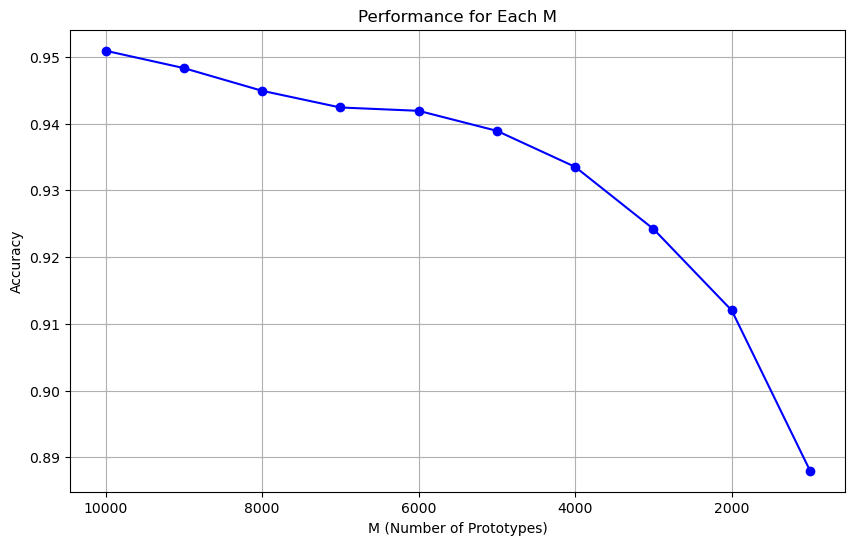

In [33]:
Ms = [10000, 9000, 8000, 7000, 6000, 5000, 4000, 3000, 2000, 1000]
accuracies = []
for M in Ms:
    print(f"For M equals {M}: ")
    x_select_train, y_select_train = equal_num_label_select_prototype(x_train_flattened, y_train, M)
    p = KNN(x_select_train, y_select_train)
    accuracy = get_accuracy(p)
    accuracies.append(accuracy)
plt.figure(figsize=(10, 6))
plt.plot(Ms, accuracies, marker='o', linestyle='-', color='b')
plt.title('Performance for Each M')
plt.xlabel('M (Number of Prototypes)')
plt.ylabel('Accuracy')
plt.gca().invert_xaxis()  # Invert x-axis to show descending values of M
plt.grid(True)


### Using K-means to cluster the training data:
Workflow:
1. First using K-means to cluster the training data.
2. For each test data, determine which cluster should be used to run KNN on.
3. Run KNN on this choosen cluster and use this cluster to predict the test data. 

In [34]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from collections import defaultdict
from scipy.spatial.distance import cdist

In [35]:
def find_proper_cluster(test_sample, cluster_centers, max_distances, densities, alpha, beta):
    # Step 1: Calculate di for each cluster
    di_values = np.linalg.norm(cluster_centers - test_sample, axis=1)
    epsilon = 1e-10 
    
    # Step 2: Filter clusters based on alpha
    min_di = np.min(di_values)
    filtered_clusters_alpha = [i for i, di in enumerate(di_values) if di <= alpha * min_di]
    
    # Step 3: Calculate Di for filtered clusters
    Di_values = {}
    for i in filtered_clusters_alpha:
        # Adding epsilon to max_distances[i] in the denominator to avoid division by zero
        Di = di_values[i] - np.sum(((test_sample - cluster_centers[i])**2 * max_distances[i]) / (max_distances[i] + epsilon))
        Di_values[i] = Di
    
    # Step 4: Filter clusters based on beta
    min_Di = min(Di_values.values())
    filtered_clusters_beta = [i for i, Di in Di_values.items() if Di <= beta * min_Di]

    # Step 5: Choose the cluster with the maximum density
    if filtered_clusters_beta:
        chosen_cluster = max(filtered_clusters_beta, key=lambda i: densities[i])
    else:
        chosen_cluster = None

    return chosen_cluster

In [ ]:
Ms = [10000, 9000, 8000, 7000, 6000, 5000, 4000, 3000, 2000, 1000]
accuracies = []
for M in Ms:
    
    #run k means to classify the data
    num_clusters = 5  # Define the number of clusters
    kmeans = KMeans(n_clusters=num_clusters)
    clusters = kmeans.fit_predict(x_train_flattened)
    clustered_data_labels = defaultdict(list)
    epsilon = 1e-10

    # Organize training data and labels by assigned cluster
    for idx, cluster_id in enumerate(clusters):
        data_label_pair = (x_train_flattened[idx], y_train[idx])
        clustered_data_labels[cluster_id].append(data_label_pair)
    
    
    # Initialize arrays to store cluster centers, max distances, and densities
    fraction_to_consider = 1/(60000 // M)  # Fraction of points to consider
    cluster_centers = np.zeros((num_clusters, x_train_flattened.shape[1]))
    max_distances = np.zeros((num_clusters, x_train_flattened.shape[1]))
    densities = np.zeros(num_clusters)

    for cluster_id in clustered_data_labels.keys():
        # Extract just the data points for the current cluster
        cluster_data_points = np.array([data_label[0] for data_label in clustered_data_labels[cluster_id]])
        
        # Determine points to consider based on fraction, select the points that closest to the center
        distances = cdist(cluster_data_points, [np.mean(cluster_data_points, axis=0)], 'euclidean').flatten()
        num_points_to_consider = max(1, int(len(cluster_data_points) * fraction_to_consider))
        closest_indices = np.argsort(distances)[:num_points_to_consider]
        cluster_data_points = cluster_data_points[closest_indices]

         # Calculate max distance in each dimension
        cluster_centers[cluster_id] = np.mean(cluster_data_points, axis=0)
        max_distances[cluster_id] = np.max(np.abs(cluster_data_points - cluster_centers[cluster_id]), axis=0)

        # Calculate density
        densities[cluster_id] = len(cluster_data_points) / (np.prod(max_distances[cluster_id]) + epsilon)

        
    knn = KNeighborsClassifier(n_neighbors=1)  # You can choose the best k by cross-validation
    # Lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []
    alpha = 1
    beta = 1

    for idx, test_sample in enumerate(x_test_flattened):
        # Find the appropriate cluster for the test sample
        chosen_cluster = find_proper_cluster(test_sample, cluster_centers, max_distances, densities, alpha, beta)

        if chosen_cluster is not None:
            # Get the training samples and labels for the chosen cluster
            train_samples, train_labels = zip(*clustered_data_labels[chosen_cluster])

            # Fit the KNN classifier on the training samples of the chosen cluster
            knn.fit(train_samples, train_labels)

            # Predict the label for the test sample
            predicted_label = knn.predict([test_sample])[0]
        else:
            # Handle case where no appropriate cluster is found, e.g., assign a default label or use another strategy
            predicted_label = 0  # default_label should be defined based on your strategy

        # Store the true label and predicted label
        true_labels.append(y_test[idx])
        predicted_labels.append(predicted_label)

    # Calculate the accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    accuracies.append(accuracy)
    print(f"For M equals {M}: ")
    print(f"Test accuracy: {accuracy}")
    
plt.figure(figsize=(10, 6))
plt.plot(Ms, accuracies, marker='o', linestyle='-', color='b')
plt.title('Performance for Each M')
plt.xlabel('M (Number of Prototypes)')
plt.ylabel('Accuracy')
plt.gca().invert_xaxis()  # Invert x-axis to show descending values of M
plt.grid(True)

For M equals 10000: 
Test accuracy: 0.9554
For M equals 9000: 
Test accuracy: 0.9529
For M equals 8000: 
Test accuracy: 0.9513
For M equals 7000: 
Test accuracy: 0.9546
For M equals 6000: 
Test accuracy: 0.9495
For M equals 5000: 
Test accuracy: 0.9499


### Using K-means and elbow

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [14]:
num_clusters = 11
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(x_train_flattened)

In [15]:
clustered_data_labels = defaultdict(list)

for idx, cluster_id in enumerate(clusters):
    data_label_pair = (x_train_flattened[idx], y_train[idx])
    clustered_data_labels[cluster_id].append(data_label_pair)

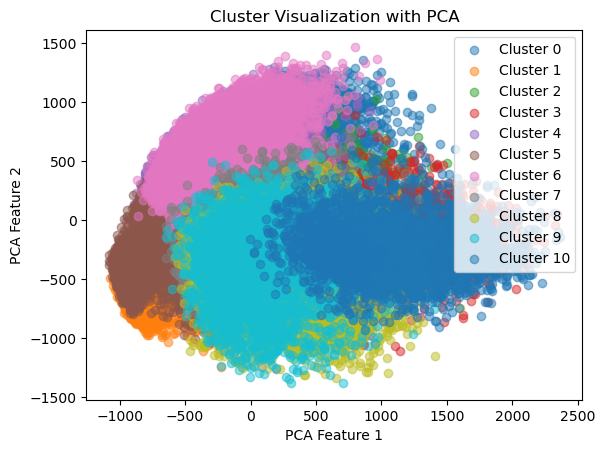

In [16]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(x_train_flattened)
fig, ax = plt.subplots()

for cluster_id in range(num_clusters):
    indices = [idx for idx, c_id in enumerate(clusters) if c_id == cluster_id]
    ax.scatter(reduced_data[indices, 0], reduced_data[indices, 1], label=f'Cluster {cluster_id}', alpha=0.5)

ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
ax.legend()
plt.title('Cluster Visualization with PCA')
plt.show()

In [17]:
def kmeans_select_prototype(M):
    cluster_centers = np.zeros((num_clusters, x_train_flattened.shape[1]))
    prototypes = []
    x_select_train, y_select_train = [], []

    for cluster_id in clustered_data_labels:
        # Extract data points and their corresponding labels
        cluster_points, _ = zip(*clustered_data_labels[cluster_id])

        num_prototypes_per_cluster = max(1, len(cluster_points) // (60000//M))
        # Calculate distances of all points in the cluster to the cluster center
        distances = cdist(cluster_points, [cluster_centers[cluster_id]], 'euclidean').flatten()

        # Get the indices of points with smallest distances to the center
        closest_point_indices = distances.argsort()[:num_prototypes_per_cluster]

        # Add selected prototypes to the list
        for i in closest_point_indices:
            x_select_train.append(clustered_data_labels[cluster_id][i][0])
            y_select_train.append(clustered_data_labels[cluster_id][i][1])

    return x_select_train, y_select_train


In [24]:
Ms = [10000, 5000, 1000]
for M in Ms:
    print(f"For M equals {M}: ")
    x_input, y_input = kmeans_select_prototype(M)
    knn = KNeighborsClassifier(n_neighbors=1)
    start_time = time.time()
    knn.fit(x_input, y_input)
    predictions = knn.predict(x_test_flattened)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"The execution time is {execution_time} seconds")
    get_accuracy(predictions)
    print()

For M equals 10000: 
The execution time is 2.213862180709839 seconds
Compute accuracy score took 0.000698089599609375 seconds
Accuracy: 0.9303

For M equals 5000: 
The execution time is 1.1969718933105469 seconds
Compute accuracy score took 0.0008299350738525391 seconds
Accuracy: 0.9128

For M equals 1000: 
The execution time is 0.3675370216369629 seconds
Compute accuracy score took 0.000659942626953125 seconds
Accuracy: 0.8388



#### Use elbow to select the best number of cluster

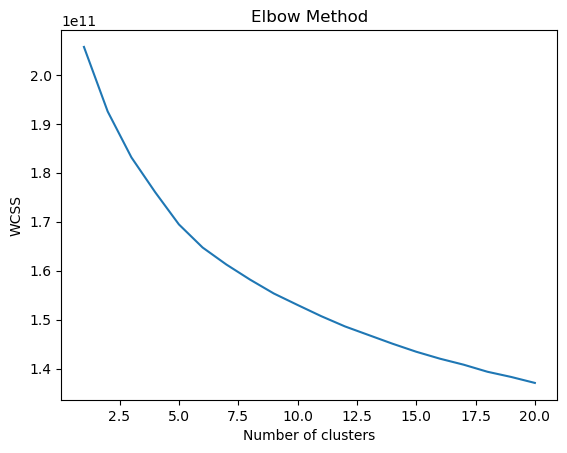

In [14]:
wcss = []
for i in range(1, 21):  # You can choose a different range
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(x_train_flattened)
    wcss.append(kmeans.inertia_)

# Plot the results
plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # within-cluster sums of squares
plt.show()

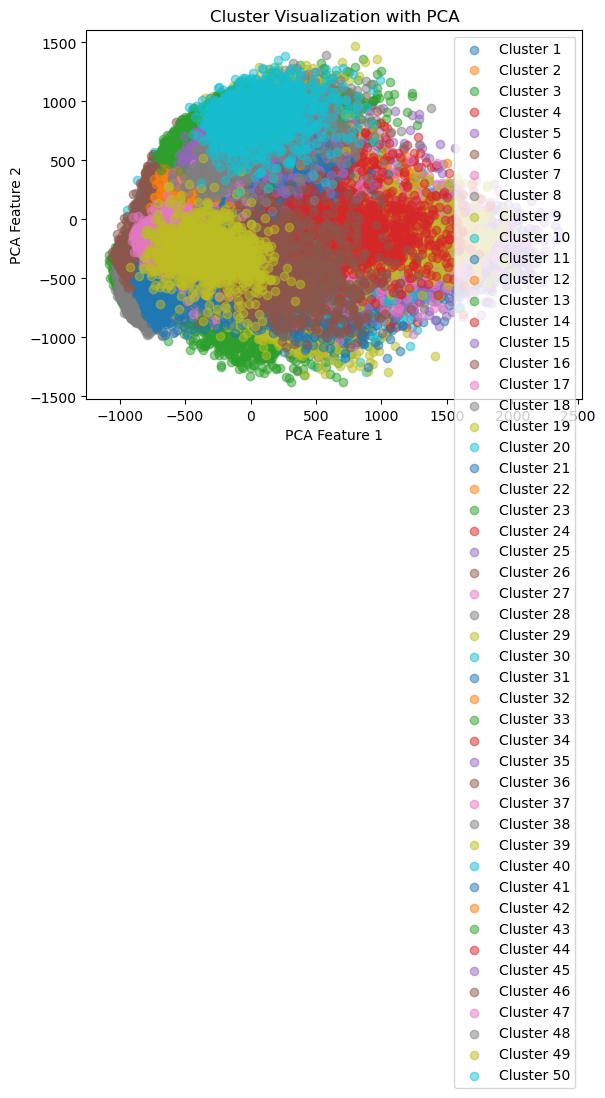

For M equals 10000: 
The execution time is 2.218975067138672 seconds
Compute accuracy score took 0.0007276535034179688 seconds
Accuracy: 0.9355

For M equals 5000: 
The execution time is 1.1333091259002686 seconds
Compute accuracy score took 0.0007331371307373047 seconds
Accuracy: 0.9206

For M equals 1000: 
The execution time is 0.34634900093078613 seconds
Compute accuracy score took 0.0007679462432861328 seconds
Accuracy: 0.8794



In [18]:
num_clusters = 50
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(x_train_flattened)

clustered_data_labels = defaultdict(list)

for idx, cluster_id in enumerate(clusters):
    data_label_pair = (x_train_flattened[idx], y_train[idx])
    clustered_data_labels[cluster_id].append(data_label_pair)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(x_train_flattened)
fig, ax = plt.subplots()

for cluster_id in range(num_clusters):
    indices = [idx for idx, c_id in enumerate(clusters) if c_id == cluster_id]
    ax.scatter(reduced_data[indices, 0], reduced_data[indices, 1], label=f'Cluster {cluster_id + 1}', alpha=0.5)

ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
ax.legend()
plt.title('Cluster Visualization with PCA')
plt.show()

Ms = [10000, 9000, 8000, 7000, 6000, 5000, 4000, 3000, 2000, 1000]
accuracies = []
for M in Ms:
    print(f"For M equals {M}: ")
    x_input, y_input = kmeans_select_prototype(M)
    knn = KNeighborsClassifier(n_neighbors=1)
    start_time = time.time()
    knn.fit(x_input, y_input)
    predictions = knn.predict(x_test_flattened)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"The execution time is {execution_time} seconds")
    accuracy = get_accuracy(predictions)
    accuracies.append(accuracy)
plt.figure(figsize=(10, 6))
plt.plot(Ms, accuracies, marker='o', linestyle='-', color='b')
plt.title('Performance for Each M')
plt.xlabel('M (Number of Prototypes)')
plt.ylabel('Accuracy')
plt.gca().invert_xaxis()  # Invert x-axis to show descending values of M
plt.grid(True)
